### Objetivos del notebook
---
En el presente notebook vamos a aprender a utilizar el algoritmo de XGBoost para trabajar con Series Temporales.

[XGBoost](https://xgboost.readthedocs.io/en/stable/) es una implementación muy popular del [Gradient Boosting](https://interactivechaos.com/es/manual/tutorial-de-machine-learning/gradient-boosting) y se ha convertido **"de facto"** en el benchmark a batir para datos tabulares.

A pesar de tener sus carencias para problemas de Series Temporales (por ejemplo: no es capaz de extrapolar una tendencia), el algoritmo es muy versátil y todo Data Scientist debe conocerlo.

El dataset con el que vamos a trabajar en este notebook contiene un total de **426 Series Temporales** que abarcan el periodo Enero'2013 - Septiembre'2015. Por tanto vamos a trabajar con **Series Temporales Multivariante**.

Cada una de estas **Series Temporales** representan las ventas <u>**MENSUALES**</u> de **un artículo en un tienda y ciudad**. El objetivo es predecir las <u>**VENTAS TOTALES DEL MES DE OCTUBRE'2015**</u>.

Al final del notebook, el alumno debe estar familiarizado con:

1. **La importancia de establecer un benchmark (CORE IDEA)** cuando empezamos a trabajar en un problema de Machine Learning. <br>
2. Saber utilizar **pandas de forma eficiente para manipular el dataset (resample de pandas, groupby etc).** <br>
3. **Combinar la información de diferentes Series Temporales para generar variables (ventas totales de un artículo, ventas totales de todos los artículos en una tienda) con las que alimentar nuestro modelo XGBoost (CORE IDEA).**<br>
4. **Saber identificar las variables autoexplicativas (COREA IDEA)** y sus principales causas.<br>
5. Comprender **la importancia de iterar rápido (realizar muchos experimentos) (CORE IDEA)** para testear diferentes hipótesis y variables que se construyen.

---

El presente notebook contiene muchas funcionalidades avanzadas que puede requerir varias lecturas para su comprensión.
Pensamos que las secciones marcadas con **CORE IDEA** son las que mayor beneficio le reportarán al alumno. Por este motivo, le animamos a que dedique especial atención a estas ideas.

Al final del notebook, hay un sección de referencias y lecturas recomendables para que el alumno pueda seguir profundizando en estos conceptos.

---

<a id='index'></a>
### Índice

[Imports del notebook](#imports_notebook)<br>
[Data Loading](#data_load)<br>
[La idea del Benchmark (**CORE IDEA**)](#benchmark)<br>
[Data Imputation](#impute)<br>
[EDA](#eda)<br>
[--> 1. EDA: Global Sales](#eda_global_sales)<br>
[--> 2. EDA: Top 3 Cities](#eda_top_3_cities)<br>
[--> 3. EDA: Top 3 Categories](#eda_top_3_categories)<br>
[Build Time Series Features (**CORE IDEA**)](#build_ts_features)<br>
[Join TS Features](#join_ts_features)<br>
[Train Test Split](#train_test_split)<br>
[Model Train](#model_train)<br>
[Model Evaluation (**COREA IDEA**)](#model_evaluation)<br>
[Prediction](#prediction)<br>

### Conclusión
[Conclusión](#conclusion)<br>

### Referencias
[Referencias y lecturas recomendables](#referencias)<br>

<a id='imports_notebook'></a>
### Imports del notebook
[Volver al índice](#index)

En este apartado hacemos los principales imports del notebook.<br>
Sobre todo vamos a trabajar con **numpy**, **pandas**, **statsmodels** y **XGBoost**.

In [ ]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("Working with these versions of libraries\n")
print("-"*50)
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"XGBoost version {xgb.__version__}")

Working with these versions of libraries

--------------------------------------------------
Numpy version 1.23.5
Pandas version 1.5.3
XGBoost version 2.0.3


In [ ]:
CWD = os.getcwd()
DATA_PATH = os.path.join(CWD, "/content/drive/MyDrive/Colab Notebooks/ML_NICO/2_time_series/data")
FILE_NAME = "ts_kaggle_train.csv"
TRAIN_CSV_PATH = os.path.join(DATA_PATH, FILE_NAME)

<a id='data_load'></a>
### Data Loading
[Volver al índice](#index)

Vamos a cargar nuestro dataset para comenzar con el EDA.

In [ ]:
df = pd.read_csv(TRAIN_CSV_PATH, index_col = 0)
df.sample(5)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
10661,2014-11-30,4_17717,20,4,79,17717,1096.516667,27.0
7946,2015-07-31,31_15438,7,31,63,15438,1048.752500,4.0
9258,2013-12-31,42_20949,14,42,71,20949,5.000000,30.0
6451,2013-11-30,31_7893,7,31,6,7893,1980.000000,15.0
9014,2014-07-31,41_2252,12,41,30,2252,419.075000,4.0


Vamos a ver que tipo de datos tenemos en nuestro dataset.

In [ ]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   14484 non-null  object 
 1   unique_id              14484 non-null  object 
 2   city_id                14484 non-null  int64  
 3   shop_id                14484 non-null  int64  
 4   item_category_id       14484 non-null  int64  
 5   item_id                14484 non-null  int64  
 6   monthly_average_price  13262 non-null  float64
 7   monthly_sales          13756 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 1018.4+ KB


In [ ]:
df["date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")

<a id='benchmark'></a>
### La idea del Benchmark (CORE IDEA)
[Volver al índice](#index)

En el presente notebook buscamos establecer un benchmark rápido.

El motivo fundamental es porque los datasets en la vida real son muy complejos y no tenemos el "lujo" de poder analizar todas y cada una de las variables <u>**ANTES DE ENTRENAR NUESTRO PRIMER MODELO.</u>**

Establecer un benchmark nos ayuda a entender cual es el punto de partida, es decir: <u>**cual es el score mínimo para este dataset.**</u>

Muchas veces este benchmark puede ser un modelo entrenado con unas pocas columnas númericas (imputando los nulos con la media). <u>**No se trata de tener el mejor modelo sino de entrenar nuestro primer modelo.**</u>

Una vez sabemos cual es el punto de partida y tenemos un notebook **"funcional"** podemos empezar a experimentar con nuestro dataset. Por **"notebook funcional"** entendemos un script/notebook que podemos ejecutar en su totalidad (loading del dataset, preprocessing, train_test_split, train y predict). En cada experimento iremos añadiendo nuevas variables, diferentes imputaciones, modelos y vamos guardando el score que obtenemos. De este manera, podemos ver la contribución de cada variables y comprobar si estamos mejorando o no respecto al benchmark.

Dado que este notebook es un benchmark, tenemos que **"acotar"** muy bien las cosas que vamos a implementar (para no irnos por las ramas).

A **grosso modo** vamos a hacer las siguientes cosas:

1. Tratar los nulos.
1. Realizar un pequeño EDA sobre el dataset.
1. Crear algunas variables rápidas para el entrenamiento.
1. Entrenar el algoritmo.
1. Evaluar el modelo.
1. Hacer el submit a Kaggle.

Empecemos:

Tenemos un total de 426 Series Temporales en el dataset:

In [ ]:
df["unique_id"].nunique()

426

Veamos cuales son las fechas min y max de nuestro dataset:

In [ ]:
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

In [ ]:
MIN_DATE = df["date"].min()
MAX_DATE = df["date"].max()

In [ ]:
print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 2013-01-31 00:00:00
Max date is 2015-10-31 00:00:00


In [ ]:
df.isnull().sum()

date                        0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
monthly_sales             728
year                        0
month                       0
dtype: int64

<a id='impute'></a>
### Data Imputation
[Volver al índice](#index)<br>

In [ ]:
sample_ts = "31_4249"

In [ ]:
df[df["unique_id"] == sample_ts]

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,year,month
5666,2013-01-31,31_4249,7,31,23,4249,1899.000000,2.0,2013,1
5743,2013-02-28,31_4249,7,31,23,4249,1599.000000,5.0,2013,2
5820,2013-03-31,31_4249,7,31,23,4249,1013.416000,6.0,2013,3
5897,2013-04-30,31_4249,7,31,23,4249,1598.900000,10.0,2013,4
5974,2013-05-31,31_4249,7,31,23,4249,1598.937500,8.0,2013,5
6051,2013-06-30,31_4249,7,31,23,4249,1599.000000,4.0,2013,6
6128,2013-07-31,31_4249,7,31,23,4249,1399.000000,4.0,2013,7
6205,2013-08-31,31_4249,7,31,23,4249,1599.000000,2.0,2013,8
6282,2013-09-30,31_4249,7,31,23,4249,1199.000000,5.0,2013,9
6359,2013-10-31,31_4249,7,31,23,4249,929.075000,4.0,2013,10


In [ ]:
df["monthly_sales"].fillna(0, inplace = True)

In [ ]:
df["monthly_average_price"] = df.groupby("unique_id", group_keys = False)["monthly_average_price"].apply(
    lambda series: series.backfill().ffill()
)

In [ ]:
df["monthly_revenue"] = df["monthly_sales"] * df["monthly_average_price"]

In [ ]:
df["ventas_precio"] = df["monthly_sales"] / df ["monthly_average_price"]

In [ ]:
df.isnull().sum()

date                     0
unique_id                0
city_id                  0
shop_id                  0
item_category_id         0
item_id                  0
monthly_average_price    0
monthly_sales            0
year                     0
month                    0
monthly_revenue          0
ventas_precio            0
dtype: int64

In [ ]:
df.sort_values(["unique_id", "date"], ascending = True, inplace = True)

In [ ]:
df[df["unique_id"] == sample_ts]

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,year,month,monthly_revenue,ventas_precio
5666,2013-01-31,31_4249,7,31,23,4249,1899.000000,2.0,2013,1,3798.000000,0.001053
5743,2013-02-28,31_4249,7,31,23,4249,1599.000000,5.0,2013,2,7995.000000,0.003127
5820,2013-03-31,31_4249,7,31,23,4249,1013.416000,6.0,2013,3,6080.496000,0.005921
5897,2013-04-30,31_4249,7,31,23,4249,1598.900000,10.0,2013,4,15989.000000,0.006254
5974,2013-05-31,31_4249,7,31,23,4249,1598.937500,8.0,2013,5,12791.500000,0.005003
6051,2013-06-30,31_4249,7,31,23,4249,1599.000000,4.0,2013,6,6396.000000,0.002502
6128,2013-07-31,31_4249,7,31,23,4249,1399.000000,4.0,2013,7,5596.000000,0.002859
6205,2013-08-31,31_4249,7,31,23,4249,1599.000000,2.0,2013,8,3198.000000,0.001251
6282,2013-09-30,31_4249,7,31,23,4249,1199.000000,5.0,2013,9,5995.000000,0.004170
6359,2013-10-31,31_4249,7,31,23,4249,929.075000,4.0,2013,10,3716.300000,0.004305


<a id='eda'></a>
### EDA
[Volver al índice](#index)<br>

Vamos a hacer un EDA rápido para ver como son nuestras Series Temporales y coger algunas ideas para futuras variables que vamos a implementar.

Al tratarse este notebook del benchmark, vamos a explorar de manera muy superficial el dataset. En posteriores ejecuciones analizaremos el dataset en más detalle, construiremos nuevas variables y volveremos a entrenar nuestro modelo.

<a id='eda_global_sales'></a>
### --> 1. EDA: Global Sales
[Volver al índice](#index)<br>

In [ ]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 14)
    plot_pacf(x = y, ax = ax3, lags = 14)

    plt.suptitle(t = title, fontsize = 20)

In [ ]:
y = df.set_index("date").resample("M")["monthly_sales"].sum()[:-1] # quitamos los registros de octubre

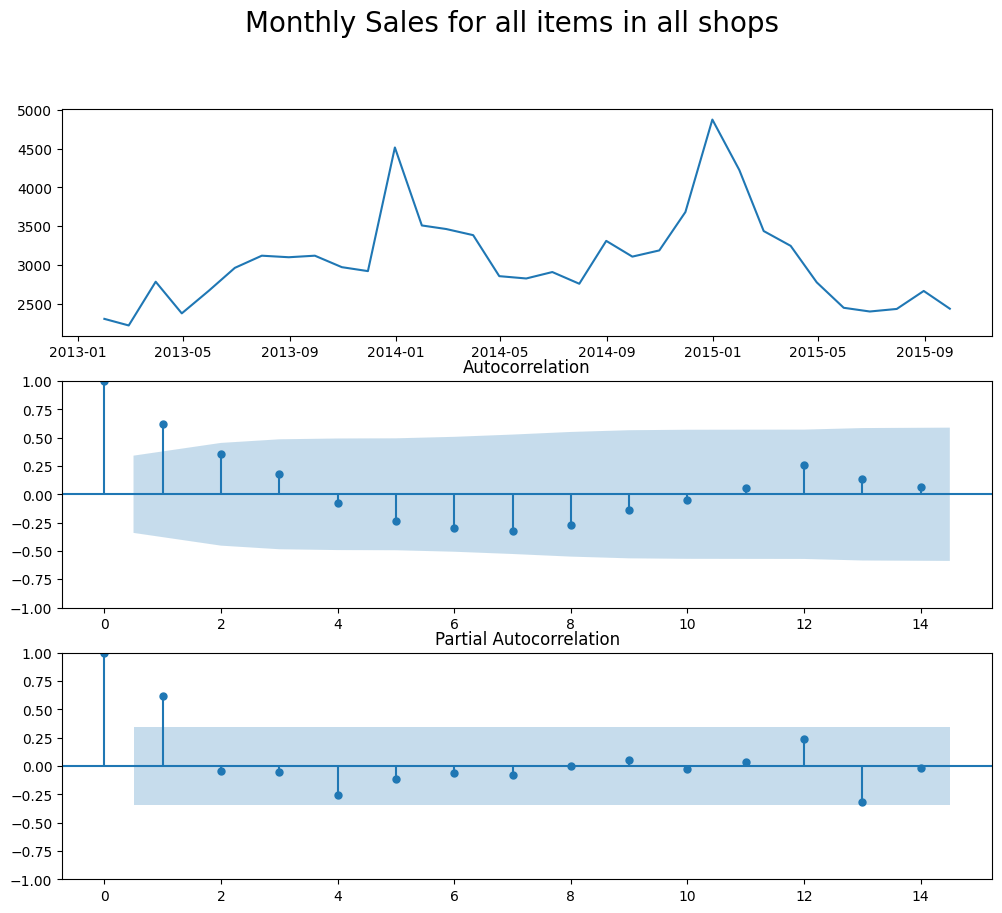

In [ ]:
plot_ts_acf_pacf(y = y, title = "Monthly Sales for all items in all shops");

Nota importante: nos estamos ayudando del gráfico de acf y pacf, pero no vamos a entrenar un modelo ARIMA.

Para resolver el problema que se nos plantea: más de 400 Series Temporales diferentes tendríamos que entrenar 400 ARIMAs (1 modelo por Serie Temporal). En cambio, con el algoritmo de XGBoost podríamos entrenar 1 único modelo.

Ahora bien, al contrario que ARIMA (que internamente construye las variables necesarias), para XGBoost debemos ser explícitos y suministrarle todas y cada una de las variables necesarias.

Del gráfico anterior ya podemos observar que las variables de lags pueden ser muy relevantes.

IDEA para los alumnos: podéis intentar analizar algunas de las 400 Series Temporales de manera individual para ver su comportamiento.

<a id='eda_top_3_cities'></a>
### --> 2. EDA: Top 3 Cities
[Volver al índice](#index)<br>

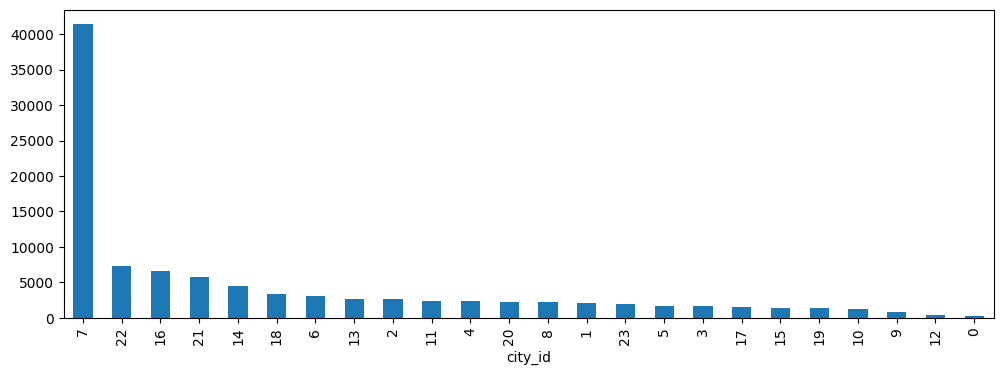

In [ ]:
(
    df.
    groupby(["city_id"])
    ["monthly_sales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

In [ ]:
df.head(5)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,year,month,monthly_revenue,ventas_precio
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,2013,1,45345.378788,0.019848
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,2013,2,41394.375000,0.017611
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,2013,3,97574.107143,0.009224
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,2013,4,42943.909091,0.016976
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,2013,5,43425.937500,0.020725


<a id='eda_top_3_categories'></a>
### --> 3. EDA: Top 3 Categories
[Volver al índice](#index)<br>

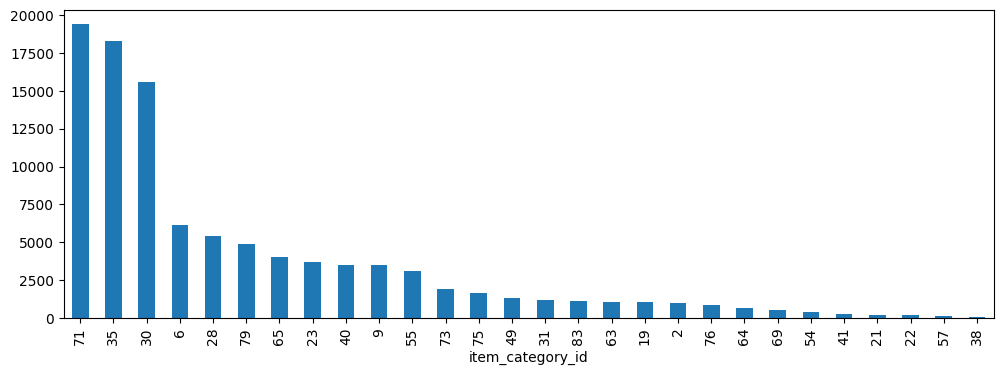

In [ ]:
(
    df.
    groupby(["item_category_id"])
    ["monthly_sales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

In [ ]:
def asignar_temporada(mes):
    if mes.month in [11, 12]:
        return 'Temporada alta'
    elif mes.month in [1, 2]:
        return 'Temporada baja'
    else:
        return 'Temporada normal'

# Aplicar la función a la columna 'date' para crear la nueva columna 'temporada'
df['temporada'] = df['date'].apply(asignar_temporada)

# Mostrar el DataFrame resultante
print(df)

            date unique_id  city_id  shop_id  item_category_id  item_id  \
0     2013-01-31  12_11365       16       12                 9    11365   
7     2013-02-28  12_11365       16       12                 9    11365   
14    2013-03-31  12_11365       16       12                 9    11365   
21    2013-04-30  12_11365       16       12                 9    11365   
28    2013-05-31  12_11365       16       12                 9    11365   
...          ...       ...      ...      ...               ...      ...   
14435 2015-06-30    7_7893       21        7                 6     7893   
14447 2015-07-31    7_7893       21        7                 6     7893   
14459 2015-08-31    7_7893       21        7                 6     7893   
14471 2015-09-30    7_7893       21        7                 6     7893   
14483 2015-10-31    7_7893       21        7                 6     7893   

       monthly_average_price  monthly_sales  year  month  monthly_revenue  \
0                1511.

In [ ]:
df = pd.get_dummies(df, columns=['temporada'], prefix=['temporada'])

In [ ]:
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,year,month,monthly_revenue,ventas_precio,temporada_Temporada alta,temporada_Temporada baja,temporada_Temporada normal
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,2013,1,45345.378788,0.019848,0,1,0
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,2013,2,41394.375000,0.017611,0,1,0
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,2013,3,97574.107143,0.009224,0,0,1
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,2013,4,42943.909091,0.016976,0,0,1
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,2013,5,43425.937500,0.020725,0,0,1


In [ ]:
df.head(5)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,year,month,monthly_revenue,ventas_precio,temporada_Temporada alta,temporada_Temporada baja,temporada_Temporada normal
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,2013,1,45345.378788,0.019848,0,1,0
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,2013,2,41394.375000,0.017611,0,1,0
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,2013,3,97574.107143,0.009224,0,0,1
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,2013,4,42943.909091,0.016976,0,0,1
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,2013,5,43425.937500,0.020725,0,0,1


In [ ]:
import pandas as pd
import numpy as np

# Crear un DataFrame de ejemplo con una columna "fecha"
data = {'fecha': pd.date_range(start='2013-01-01', end='2015-09-30')}
df["fecha"] = pd.DataFrame(data)

# Función para verificar si una fecha es un día laborable (de lunes a viernes)
def es_dia_laborable(fecha):
    return fecha.weekday() < 5  # 0 a 4 representan lunes a viernes

# Aplicar la función a la columna "fecha" y crear una nueva columna "es_laborable"
df['es_laborable'] = df['fecha'].apply(es_dia_laborable)

# Mostrar el DataFrame resultante
print(df)

            date unique_id  city_id  shop_id  item_category_id  item_id  \
0     2013-01-31  12_11365       16       12                 9    11365   
7     2013-02-28  12_11365       16       12                 9    11365   
14    2013-03-31  12_11365       16       12                 9    11365   
21    2013-04-30  12_11365       16       12                 9    11365   
28    2013-05-31  12_11365       16       12                 9    11365   
...          ...       ...      ...      ...               ...      ...   
14435 2015-06-30    7_7893       21        7                 6     7893   
14447 2015-07-31    7_7893       21        7                 6     7893   
14459 2015-08-31    7_7893       21        7                 6     7893   
14471 2015-09-30    7_7893       21        7                 6     7893   
14483 2015-10-31    7_7893       21        7                 6     7893   

       monthly_average_price  monthly_sales  year  month  monthly_revenue  \
0                1511.

In [ ]:
df = pd.get_dummies(df, columns=['fecha'], prefix=['fecha'])

In [ ]:
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,year,month,...,fecha_2015-09-21 00:00:00,fecha_2015-09-22 00:00:00,fecha_2015-09-23 00:00:00,fecha_2015-09-24 00:00:00,fecha_2015-09-25 00:00:00,fecha_2015-09-26 00:00:00,fecha_2015-09-27 00:00:00,fecha_2015-09-28 00:00:00,fecha_2015-09-29 00:00:00,fecha_2015-09-30 00:00:00
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,2013,1,...,0,0,0,0,0,0,0,0,0,0
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,2013,2,...,0,0,0,0,0,0,0,0,0,0
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,2013,3,...,0,0,0,0,0,0,0,0,0,0
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,2013,4,...,0,0,0,0,0,0,0,0,0,0
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,2013,5,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df = pd.get_dummies(df, columns=['es_laborable'], prefix=['es_laborable'])

In [ ]:
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,year,month,...,fecha_2015-09-23 00:00:00,fecha_2015-09-24 00:00:00,fecha_2015-09-25 00:00:00,fecha_2015-09-26 00:00:00,fecha_2015-09-27 00:00:00,fecha_2015-09-28 00:00:00,fecha_2015-09-29 00:00:00,fecha_2015-09-30 00:00:00,es_laborable_False,es_laborable_True
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,2013,1,...,0,0,0,0,0,0,0,0,0,1
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,2013,2,...,0,0,0,0,0,0,0,0,0,1
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,2013,3,...,0,0,0,0,0,0,0,0,0,1
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,2013,4,...,0,0,0,0,0,0,0,0,0,1
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,2013,5,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
import pandas as pd

# Supongamos que ya tienes un DataFrame llamado "df"
# Encuentra las columnas que comienzan con "fecha"
columnas_fecha = [col for col in df.columns if col.startswith('fecha')]


# Mostrar el DataFrame resultante sin las columnas seleccionadas
print(df)

            date unique_id  city_id  shop_id  item_category_id  item_id  \
0     2013-01-31  12_11365       16       12                 9    11365   
7     2013-02-28  12_11365       16       12                 9    11365   
14    2013-03-31  12_11365       16       12                 9    11365   
21    2013-04-30  12_11365       16       12                 9    11365   
28    2013-05-31  12_11365       16       12                 9    11365   
...          ...       ...      ...      ...               ...      ...   
14435 2015-06-30    7_7893       21        7                 6     7893   
14447 2015-07-31    7_7893       21        7                 6     7893   
14459 2015-08-31    7_7893       21        7                 6     7893   
14471 2015-09-30    7_7893       21        7                 6     7893   
14483 2015-10-31    7_7893       21        7                 6     7893   

       monthly_average_price  monthly_sales  year  month  ...  \
0                1511.512626      

In [ ]:
df.info(all)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14484 entries, 0 to 14483
Data columns (total 1020 columns):
 #     Column                      Dtype         
---    ------                      -----         
 0     date                        datetime64[ns]
 1     unique_id                   object        
 2     city_id                     int64         
 3     shop_id                     int64         
 4     item_category_id            int64         
 5     item_id                     int64         
 6     monthly_average_price       float64       
 7     monthly_sales               float64       
 8     year                        int64         
 9     month                       int64         
 10    monthly_revenue             float64       
 11    ventas_precio               float64       
 12    temporada_Temporada alta    uint8         
 13    temporada_Temporada baja    uint8         
 14    temporada_Temporada normal  uint8         
 15    fecha_2013-01-01 00:00:00   uint

<a id='build_ts_features'></a>
### Build Time Series Features (**CORE IDEA**)
[Volver al índice](#index)<br>

Dado que vamos a tener que iterar muchas veces sobre nuestro dataset, nos interesa tener todo el código encapsulado en funciones para su reutilización.

Uno de los apartados clave será la generación de variables.

Como hemos visto antes, nuestro dataset contiene más de 400 Series Temporales.

Algunas de estas Series Temporales las podemos agrupar para sacar nueva información.

Por ejemplo, podemos construir una variables del estilo:

1. Las ventas totales por ITEM_ID (la menor granularidad posible).
2. Las ventas totales por ITEM_CATEGORY_ID y SHOP_ID (una granularidad mayor a la 1).
3. Las ventas totales por SHOP_ID (una granularidad mayor).
4. Y todas las combinaciones que queramos intermedias.

In [ ]:
df.head(5)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,year,month,...,fecha_2015-09-23 00:00:00,fecha_2015-09-24 00:00:00,fecha_2015-09-25 00:00:00,fecha_2015-09-26 00:00:00,fecha_2015-09-27 00:00:00,fecha_2015-09-28 00:00:00,fecha_2015-09-29 00:00:00,fecha_2015-09-30 00:00:00,es_laborable_False,es_laborable_True
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,2013,1,...,0,0,0,0,0,0,0,0,0,1
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,2013,2,...,0,0,0,0,0,0,0,0,0,1
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,2013,3,...,0,0,0,0,0,0,0,0,0,1
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,2013,4,...,0,0,0,0,0,0,0,0,0,1
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,2013,5,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
def build_ts_vars1(df, gb_list, target_column, agg_func, agg_func_name):

    assert "date" in df.columns.tolist(), "Date must be in df columns"

    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("M")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )

    gb_df_[f"{new_name}_lag1"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(1)
    )

    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)

    return gb_df_

In [ ]:
GB_LIST1 = ["item_id"]
TARGET_COLUMN = "monthly_sales"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_1 = build_ts_vars1(
    df = df,
    gb_list = GB_LIST1,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME

)

vars_ts_1.head(10)

Dropping columns that might cause target leakage item_id_monthly_sales_sum


,item_id,date,item_id_monthly_sales_sum_lag1
0,32,2013-01-31,NaN
1,32,2013-02-28,24.0
2,32,2013-03-31,20.0
3,32,2013-04-30,13.0
4,32,2013-05-31,11.0
5,32,2013-06-30,6.0
6,32,2013-07-31,11.0
7,32,2013-08-31,10.0
8,32,2013-09-30,9.0
9,32,2013-10-31,2.0


In [ ]:
def build_ts_vars2(df, gb_list, target_column, agg_func, agg_func_name):

    assert "date" in df.columns.tolist(), "Date must be in df columns"

    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("3M")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )

    gb_df_[f"{new_name}_lag1"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(1)
    )

    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)

    return gb_df_

In [ ]:
GB_LIST2 = ["shop_id"]
TARGET_COLUMN = "ventas_precio"
AGG_FUNC = np.mean
AGG_FUNC_NAME = "mean"

vars_ts_2 = build_ts_vars2(
    df = df,
    gb_list = GB_LIST2,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME

)

vars_ts_2.head(10)

Dropping columns that might cause target leakage shop_id_ventas_precio_mean


,shop_id,date,shop_id_ventas_precio_mean_lag1
0,3,2013-01-31,NaN
1,3,2013-04-30,0.000836
2,3,2013-07-31,0.000485
3,3,2013-10-31,0.001466
4,3,2014-01-31,0.002478
5,3,2014-04-30,0.003054
6,3,2014-07-31,0.004733
7,3,2014-10-31,0.002760
8,3,2015-01-31,0.002517
9,3,2015-04-30,0.006130


In [ ]:
def build_ts_vars3(df, gb_list, target_column, agg_func, agg_func_name):

    assert "date" in df.columns.tolist(), "Date must be in df columns"

    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("M")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )

    gb_df_[f"{new_name}_lag1"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(1)
    )

    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)

    return gb_df_

In [ ]:
GB_LIST3 = ["item_category_id", "shop_id"]
TARGET_COLUMN = "monthly_average_price"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_3 = build_ts_vars3(
    df = df,
    gb_list = GB_LIST3,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME

)

vars_ts_3.head(10)

Dropping columns that might cause target leakage item_category_id_shop_id_monthly_average_price_sum


,item_category_id,shop_id,date,item_category_id_shop_id_monthly_average_price_sum_lag1
0,2,6,2013-01-31,NaN
1,2,6,2013-02-28,2390.0
2,2,6,2013-03-31,2390.0
3,2,6,2013-04-30,2390.0
4,2,6,2013-05-31,2290.0
5,2,6,2013-06-30,2290.0
6,2,6,2013-07-31,2390.0
7,2,6,2013-08-31,2390.0
8,2,6,2013-09-30,2490.0
9,2,6,2013-10-31,2490.0


<a id='join_ts_features'></a>
### Join TS Features
[Volver al índice](#index)<br>

In [ ]:
df.isnull().sum()

date                         0
unique_id                    0
city_id                      0
shop_id                      0
item_category_id             0
                            ..
fecha_2015-09-28 00:00:00    0
fecha_2015-09-29 00:00:00    0
fecha_2015-09-30 00:00:00    0
es_laborable_False           0
es_laborable_True            0
Length: 1020, dtype: int64

En este apartado, hacemos el merge del full_df con las variables auxiliares.

Debemos controlar muy bien el merge, para no provocar un cartesiano.

In [ ]:
print(df.shape)

df = pd.merge(df, vars_ts_1, on = ["date"] + GB_LIST1, how = "left")

print(df.shape)

(14484, 1020)
(14484, 1021)


In [ ]:
print(df.shape)

df1 = pd.merge(df, vars_ts_2, on = ["date"] + GB_LIST2, how = "left")

print(df1.shape)

(14484, 1021)
(14484, 1022)


In [ ]:
print(df.shape)

df2 = pd.merge(df1, vars_ts_3, on = ["date"] + GB_LIST3, how = "left")

print(df2.shape)

(14484, 1021)
(14484, 1023)


In [ ]:
df2["item_id_monthly_sales_sum_lag1"] = df2.groupby("unique_id", group_keys = False)["item_id_monthly_sales_sum_lag1"].apply(
    lambda series: series.backfill().ffill()
)

In [ ]:
df2["shop_id_ventas_precio_mean_lag1"] = df2.groupby("unique_id", group_keys = False)["shop_id_ventas_precio_mean_lag1"].apply(
    lambda series: series.backfill().ffill()
)

In [ ]:
df2["item_category_id_shop_id_monthly_average_price_sum_lag1"] = df2.groupby("unique_id", group_keys = False)["item_category_id_shop_id_monthly_average_price_sum_lag1"].apply(
    lambda series: series.backfill().ffill()
)

In [ ]:
df2.isnull().sum()

date                                                       0
unique_id                                                  0
city_id                                                    0
shop_id                                                    0
item_category_id                                           0
                                                          ..
es_laborable_False                                         0
es_laborable_True                                          0
item_id_monthly_sales_sum_lag1                             0
shop_id_ventas_precio_mean_lag1                            0
item_category_id_shop_id_monthly_average_price_sum_lag1    0
Length: 1023, dtype: int64

<a id='train_test_split'></a>
### Train Test Split
[Volver al índice](#index)<br>

In [ ]:
df2.columns.tolist()

['date',
 'unique_id',
 'city_id',
 'shop_id',
 'item_category_id',
 'item_id',
 'monthly_average_price',
 'monthly_sales',
 'year',
 'month',
 'monthly_revenue',
 'ventas_precio',
 'temporada_Temporada alta',
 'temporada_Temporada baja',
 'temporada_Temporada normal',
 'fecha_2013-01-01 00:00:00',
 'fecha_2013-01-02 00:00:00',
 'fecha_2013-01-03 00:00:00',
 'fecha_2013-01-04 00:00:00',
 'fecha_2013-01-05 00:00:00',
 'fecha_2013-01-06 00:00:00',
 'fecha_2013-01-07 00:00:00',
 'fecha_2013-01-08 00:00:00',
 'fecha_2013-01-09 00:00:00',
 'fecha_2013-01-10 00:00:00',
 'fecha_2013-01-11 00:00:00',
 'fecha_2013-01-12 00:00:00',
 'fecha_2013-01-13 00:00:00',
 'fecha_2013-01-14 00:00:00',
 'fecha_2013-01-15 00:00:00',
 'fecha_2013-01-16 00:00:00',
 'fecha_2013-01-17 00:00:00',
 'fecha_2013-01-18 00:00:00',
 'fecha_2013-01-19 00:00:00',
 'fecha_2013-01-20 00:00:00',
 'fecha_2013-01-21 00:00:00',
 'fecha_2013-01-22 00:00:00',
 'fecha_2013-01-23 00:00:00',
 'fecha_2013-01-24 00:00:00',
 'fecha_20

In [ ]:
COLUMNS_TO_DROP = ["monthly_revenue", "ventas_precio", "year", "month",
]

df2.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [ ]:
df2.set_index("unique_id", inplace = True)

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14484 entries, 12_11365 to 7_7893
Columns: 1018 entries, date to item_category_id_shop_id_monthly_average_price_sum_lag1
dtypes: datetime64[ns](1), float64(5), int64(4), uint8(1008)
memory usage: 15.1+ MB


In [ ]:
train_index = sorted(list(df2["date"].unique()))[:-2]

valida_index = [sorted(list(df2["date"].unique()))[-2]]

test_index = [sorted(list(df2["date"].unique()))[-1]]

In [ ]:
print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Our validation index is {valida_index}\n")
print(f"Our test/prediction index is {test_index}\n")

Our train index is [numpy.datetime64('2013-01-31T00:00:00.000000000'), numpy.datetime64('2013-02-28T00:00:00.000000000')] - ... - [numpy.datetime64('2015-07-31T00:00:00.000000000'), numpy.datetime64('2015-08-31T00:00:00.000000000')]

Our validation index is [numpy.datetime64('2015-09-30T00:00:00.000000000')]

Our test/prediction index is [numpy.datetime64('2015-10-31T00:00:00.000000000')]



In [ ]:
X_train = df2[df2["date"].isin(train_index)].drop(['monthly_sales', "date"], axis=1)
Y_train = df2[df2["date"].isin(train_index)]['monthly_sales']

X_valida = df2[df2["date"].isin(valida_index)].drop(['monthly_sales', "date"], axis=1)
Y_valida = df2[df2["date"].isin(valida_index)]['monthly_sales']

X_test = df2[df2["date"].isin(test_index)].drop(['monthly_sales', "date"], axis = 1)
Y_test = df2[df2["date"].isin(test_index)]['monthly_sales']

In [ ]:
X_test

,city_id,shop_id,item_category_id,item_id,monthly_average_price,temporada_Temporada_alta,temporada_Temporada_baja,temporada_Temporada_normal,fecha_2013_01_01_00:00:00,fecha_2013_01_02_00:00:00,...,fecha_2015_09_26_00:00:00,fecha_2015_09_27_00:00:00,fecha_2015_09_28_00:00:00,fecha_2015_09_29_00:00:00,fecha_2015_09_30_00:00:00,es_laborable_False,es_laborable_True,item_id_monthly_sales_sum_lag1,shop_id_ventas_precio_mean_lag1,item_category_id_shop_id_monthly_average_price_sum_lag1
unique_id,,,,,,,,,,,,,,,,,,,,,
12_11365,16,12,9,11365,995.680556,0,0,1,0,0,...,0,0,0,0,0,0,1,21.0,0.033311,3436.692617
12_11369,16,12,9,11369,1321.367605,0,0,1,0,0,...,0,0,0,0,0,0,1,30.0,0.033311,3436.692617
12_11370,16,12,9,11370,681.715341,0,0,1,0,0,...,0,0,0,0,0,0,1,30.0,0.033311,3436.692617
12_11373,16,12,9,11373,437.929115,0,0,1,0,0,...,0,0,0,0,0,0,1,30.0,0.033311,3436.692617
12_12231,16,12,49,12231,350.000000,0,0,1,0,0,...,0,0,0,0,0,1,0,2.0,0.033311,350.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7_5822,21,7,35,5822,1149.000000,0,0,1,0,0,...,0,0,0,0,0,1,0,244.0,0.506239,1149.000000
7_6185,21,7,30,6185,499.000000,0,0,1,0,0,...,0,0,0,0,0,1,0,19.0,0.506239,798.000000
7_6497,21,7,28,6497,749.000000,0,0,1,0,0,...,0,0,0,0,0,1,0,31.0,0.506239,1948.000000


<a id='model_train'></a>
### Model Train
[Volver al índice](#index)<br>

Entrenamos nuestro modelo de Machine Learning (benchmark).

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14484 entries, 0 to 14483
Columns: 1021 entries, date to item_id_monthly_sales_sum_lag1
dtypes: datetime64[ns](1), float64(5), int64(6), object(1), uint8(1008)
memory usage: 15.5+ MB


In [ ]:
df["date"] = df["date"].dt.strftime("%Y-%m-%d")

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14484 entries, 12_11365 to 7_7893
Columns: 1018 entries, date to item_category_id_shop_id_monthly_average_price_sum_lag1
dtypes: datetime64[ns](1), float64(5), int64(4), uint8(1008)
memory usage: 15.1+ MB


In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.2 MB/s eta 0:00:00


In [ ]:
import catboost
from catboost import CatBoostClassifier, Pool

# Crear un objeto de modelo CatBoost
model = CatBoostClassifier(iterations=1000,  # Número de iteraciones (ajusta según tus necesidades)
                           learning_rate=0.1,  # Tasa de aprendizaje (ajusta según tus necesidades)
                           depth=6,  # Profundidad máxima del árbol (ajusta según tus necesidades)
                           loss_function='MultiClass',  # Función de pérdida para problemas de clasificación múltiple
                           verbose=200)  # Controla la cantidad de información de registro

In [ ]:


# Entrenar el modelo en los datos de entrenamiento
model.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), early_stopping_rounds=100, verbose=200)

# Realizar predicciones en el conjunto de prueba
predictions = model.predict(X_test)



In [ ]:
model.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], early_stopping_rounds=100, verbose=200)

0:	learn: 3.1846975	test: 3.1846975	test1: 3.1379100	best: 3.1379100 (0)	total: 164ms	remaining: 2m 44s
200:	learn: 2.1972446	test: 2.1972446	test1: 2.1293579	best: 2.1292757 (109)	total: 44.6s	remaining: 2m 57s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.129275734
bestIteration = 109

Shrink model to first 110 iterations.


In [ ]:
# Realizar predicciones en el conjunto de prueba
predictions = model.predict(X_test)


In [ ]:
# Calcular la precisión del modelo u otras métricas de evaluación según tus necesidades
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.0


<a id='model_evaluation'></a>
### Model Evaluation (**CORE IDEA**)
[Volver al índice](#index)<br>

ValueError: tree must be Booster, XGBModel or dict instance

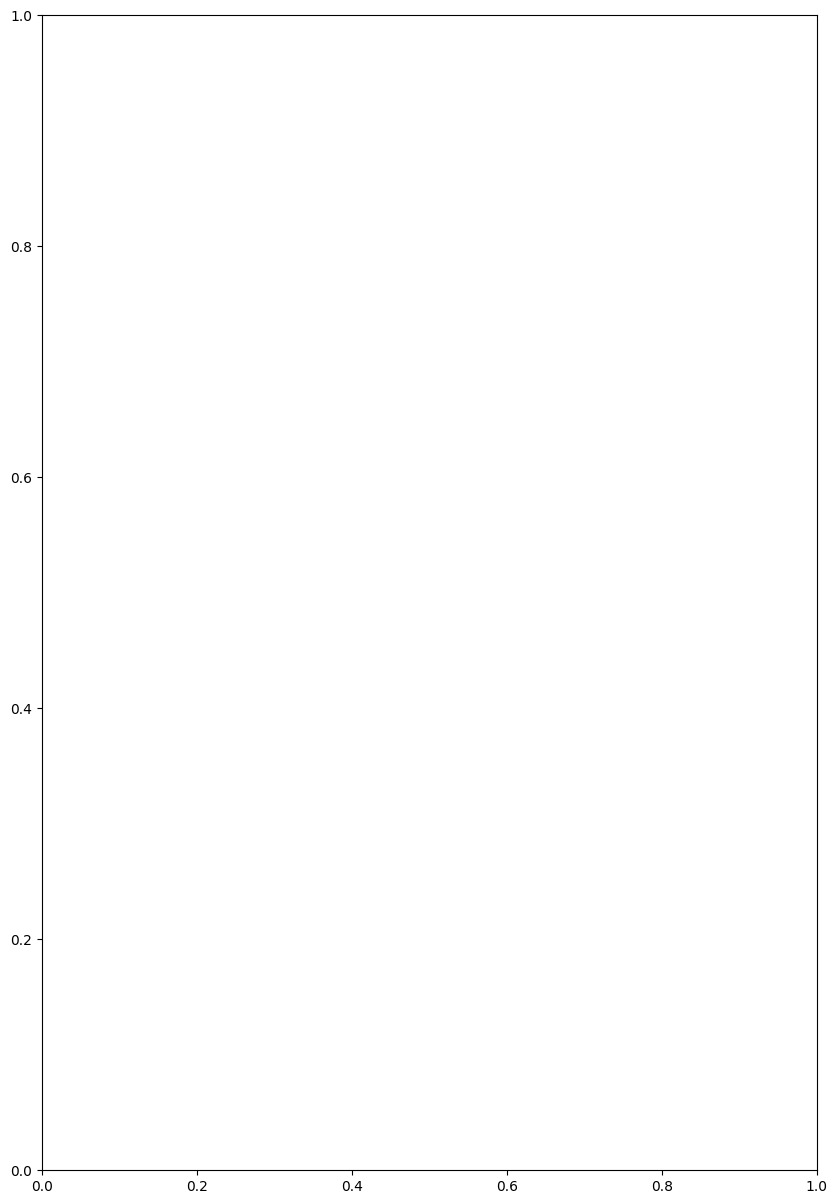

In [ ]:
fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

<a id='prediction'></a>
### Prediction
[Volver al índice](#index)<br>

En este apartado vamos a utilizar el modelo entrenado para hacer una predicción y posteriormente enviar el submit a Kaggle.

In [ ]:
if "monthly_sales" in X_test.columns:
    X_test.drop("monthly_sales", axis = 1, inplace = True)

Y_test_predict = model.predict(X_test)
X_test["monthly_sales"] = Y_test_predict

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="12_11365": Cannot convert 'b'12_11365'' to float

In [ ]:
X_test.reset_index(inplace = True)

In [ ]:
Y_train_predict = model.predict(X_train)
Y_valida_predict = model.predict(X_valida)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

In [ ]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

In [ ]:
(
    X_test[["unique_id", "monthly_sales"]]
    .to_csv(f"submission_train_{rmse_train}_valida_{rmse_valida}.csv", index = False)
)

<a id='conclusion'></a>
### Conclusión
[Volver al índice](#index)<br>

En este notebook hemos explorado la importancia en Machine Learning de utilizar un modelo benchmark cuando nos enfrentamos por primera vez a un nuevo dataset.

Establecer el benchmark nos ayuda a entender cual es el punto de partida.

Al entrenar un modelo, tenemos ya un notebook funcional que nos permite entrar en la siguiente loop:

1. Hacer un poco más de EDA.
1. Construir nuevas variables.
1. Probar estas variables en el modelo.
1. Guardar el score para ver la mejora o no (Kaggle Submit).
1. Volver al punto 1.

A continuación dejamos algunas ideas que los alumnos pueden implementar para mejorar el benchmark:

1. Probad otras combinaciones de variables.
1. Darle más profundidad a los lags/shifts.
1. Implementar medias móviles (ojo variables autoexplicativas).
1. Utilizar otras columnas en vez de MONTHLY_SALES para construir las variables.
1. Probar otros algoritmos.
1. Tunnear los hiperparametros del modelo.

### Happy Kaggling :)

<a id='referencias'></a>
### Referencias y lecturas recomendables
[Volver al índice](#index)<br>

A continuación dejamos algunos links útiles para profundizar en algunos de los conceptos que hemos visto en el notebook:

[The importance of Benchmarking](https://blog.bigml.com/2020/03/20/machine-learning-benchmarking-youre-doing-it-wrong/)

[Tree Based Models and Extrapolation (MUY RECOMENDABLE)](https://shanminlin.medium.com/how-to-help-tree-based-models-extrapolate-7954287b1219)

[XGBoost](https://xgboost.readthedocs.io/en/stable/)